# Исследование поведения пользователей мобильного приложения

## Описание проекта  
Стартап, который продаёт продукты питания, хочет разобраться, как ведут себя пользователи вашего мобильного приложения.  

Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?  

После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.  

Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.  

В случае общей аналитики и A/A/B-эксперимента работайте с одними и теми же данными. В реальных проектах всегда идут эксперименты. Аналитики исследуют качество работы приложения по общим данным, не учитывая принадлежность пользователей к экспериментам.

## Описание данных

Каждая запись в логе — это действие пользователя, или событие.

EventName — название события;  
DeviceIDHash — уникальный идентификатор пользователя;  
EventTimestamp — время события;  
ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

### Шаг. Откройте файл с данными и изучите общую информацию

In [1]:
#Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import math as mth
from scipy import stats as st
from datetime import datetime, date, time
import warnings
warnings.simplefilter("ignore")
plt.rcParams["figure.figsize"] = (10,5)

In [2]:
df = pd.read_csv('logs_exp.csv', sep='\t')

In [3]:
df.head(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


### Шаг. Подготовьте данные

- Замените названия столбцов на удобные для нас;

In [4]:
df.columns = ['event_name', 'device_id', 'timestamp', 'experiment_id']

- Проверим пропуски и типы данных. Откорректируем, если нужно;

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   event_name     244126 non-null  object
 1   device_id      244126 non-null  int64 
 2   timestamp      244126 non-null  int64 
 3   experiment_id  244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [6]:
# Проверим на пропуски
df.isnull().sum()

event_name       0
device_id        0
timestamp        0
experiment_id    0
dtype: int64

In [7]:
# Проверим наличие дубликатов
df.duplicated().sum()

413

In [8]:
# Удалим дубликаты
df = df.drop_duplicates()

- Добавим столбец даты и времени, а также отдельный столбец дат;

In [9]:
#Создадим новый столбец и откорректируем типы данных
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df['date'] = df['datetime'].dt.date

In [10]:
df

,event_name,device_id,timestamp,experiment_id,datetime,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


#### Вывод
В таблице были заменены названия столбцов, удалены 413 дубликатов, откорректированы типы данных, добавлены 2 столбца с датой и датой/временем. Пропуски в таблице отсутствуют.

### Шаг. Изучим и проверим данные

- Сколько всего событий в логе?

In [11]:
# всего событий
df['event_name'].count()

243713

In [12]:
#число уникальных событий
df['event_name'].nunique()

5

In [13]:
# Посмотрим на количество событий каждого вида
df['event_name'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

- Сколько всего пользователей в логе?

In [14]:
#число уникальных пользователей
df['device_id'].nunique()

7551

- Сколько в среднем событий приходится на пользователя?

In [15]:
df_events = df.pivot_table(index='device_id', values='event_name', aggfunc='count') 
print('В среднем на пользователя приходится событий:', int(df_events.mean()))

В среднем на пользователя приходится событий: 32


Проверим насколько уместно среднее значение. Посмотрим распределение кол-ва событий на пользователя:

In [16]:
df_events.describe()

,event_name
count,7551.000000
mean,32.275593
std,65.154219
min,1.000000
25%,9.000000
50%,20.000000
75%,37.000000
max,2307.000000


Действительно есть "Выбросы" свыше 2000 событий. Рациональнее при такой ситуации использовать медиану, а не среднее

In [17]:
print('Усредненное (Медианное) кол-во событий на пользователя :', int(df_events.median()))

Усредненное (Медианное) кол-во событий на пользователя : 20


- Данными за какой период мы располагаем? Найдём максимальную и минимальную дату. Построим гистограмму по дате и времени.  
Можно ли быть уверенным, что у нас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определим, с какого момента данные полные и отбросим более старые. Данными за какой период времени мы располагаем на самом деле?

In [18]:
print('Максимальная дата', df['date'].min())

Максимальная дата 2019-07-25


In [19]:
print('Минимальная дата',df['date'].max())

Минимальная дата 2019-08-07


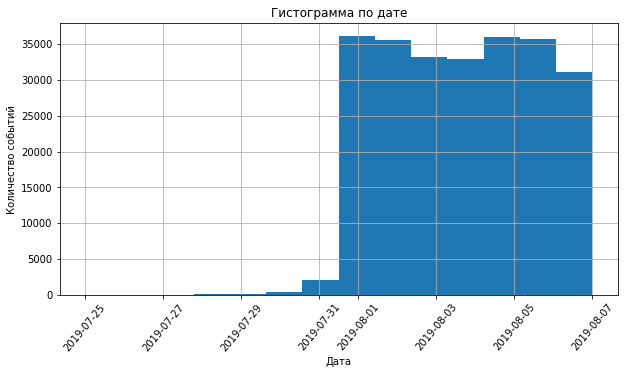

In [20]:
df['date'].hist(bins = 14)
plt.title('Гистограмма по дате')
plt.xlabel("Дата")
plt.ylabel('Количество событий')
plt.xticks(rotation=50); 


По гистограмме видно, что до 01.08.201 совершается очень мало событий. Скорее всего как раз с этой даты все данные доехали, и можно оценивать результаты экспериментов.

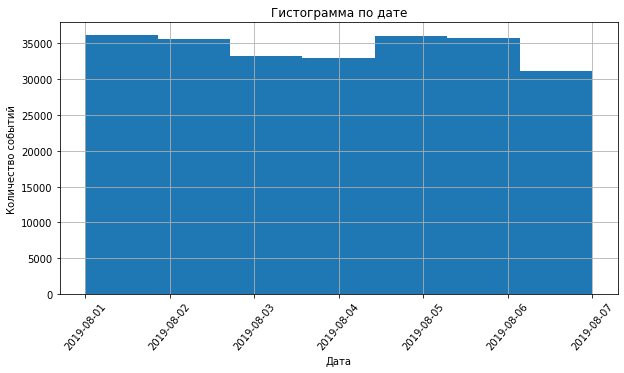

In [21]:
df['date'] = pd.to_datetime(df['date'])
df_new_data = df.query('date > "2019-07-31"')
df_new_data['date'].hist(bins = 7).set_title('Гистограмма по дате')
plt.ylabel('Количество событий')
plt.xlabel("Дата")
plt.xticks(rotation=50);

Теперь гистограмма выглядит наполненно на всем протяжение времени.

- Много ли событий и пользователей мы потеряли, отбросив старые данные?

In [22]:
# Посмотрим, сколько событий было потеряно
df_old_data = df.query('date <= "2019-07-31"')
print('Было потеряно', df_old_data['event_name'].count(), 'событий')
print('или', round((df_old_data['event_name'].count())/df['event_name'].count()*100,2), '% событий')

Было потеряно 2826 событий
или 1.16 % событий


In [23]:
# Посмотрим, сколько пользователей было потеряно
devices_lost = 0
for row in df_new_data:
    if row not in df_old_data['device_id'].unique():
        devices_lost +=1 
print('Было потеряно', devices_lost, 'пользователей')
print('или', round((devices_lost)/df['device_id'].nunique()*100,2), '% пользователей')

Было потеряно 6 пользователей
или 0.08 % пользователей


In [24]:
users = df['device_id'].nunique()

In [25]:
new_users = df_new_data['device_id'].nunique()

In [26]:
print('Было потеряно', users - new_users, 'пользователей,')
print('что составляет ', round((users - new_users)/users*100,2), '%.')

Было потеряно 17 пользователей,
что составляет  0.23 %.


- Проверим, что у нас есть пользователи из всех трёх экспериментальных групп.

In [27]:
#количество событий для каждой группы
df_new_data['experiment_id'].value_counts()

248    84563
246    79302
247    77022
Name: experiment_id, dtype: int64

In [28]:
#количество пользователей для каждой группы
df_new_data.groupby('experiment_id')['device_id'].nunique()

experiment_id
246    2484
247    2513
248    2537
Name: device_id, dtype: int64

У нас есть примерно одинаковое количество пользователей из всех трёх экспериментальных групп. 

#### Вывод:  
В ходе проверки данных выяснилось, что данные предоставлены с 25 июля по 7 августа. Кол-во событий, происходивших в июле  незначительно по сравнению с августовскими. Поэтому июльские данные принято исключить из анализа. В ходе исключения(отрезания) было отрезано 0,23% пользователей и 1,16% событий - что вполне допустимо, и существенно не должно повлиять на дальнейший анализ. Усредненное (Медианное) кол-во событий на пользователя : 20. Кол-во пользователей в каждой группе осталось примерно 2,5 тысячи, а событий примерно по 80 тысяч, это довольно одинаковые данные.

### Шаг. Изучим воронку событий

- Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.

In [29]:
df_new_data['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

В логе есть 5 событий, по частоте: показ пользователю главного экрана, показ экрана с предложением, показ экрана корзины, показ экрана с подтверждением оплаты, показ руководства

- Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.                     

In [30]:
#Сгруппируем датафрейм по полю event_name и посчитаем пользователей
df_new_data_events= df_new_data.groupby('event_name').agg({'device_id': 'nunique'}).sort_values(by='device_id', ascending=False)
df_new_data_events

,device_id
event_name,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539
Tutorial,840


In [31]:
# Посчитаем долю пользователей, которые хоть раз совершали событие
df_new_data_events['share_users'] = round(df_new_data_events['device_id']/len(df_new_data['device_id'].unique()), 3) * 100
df_new_data_events

,device_id,share_users
event_name,,
MainScreenAppear,7419,98.5
OffersScreenAppear,4593,61.0
CartScreenAppear,3734,49.6
PaymentScreenSuccessful,3539,47.0
Tutorial,840,11.1


Как видим, у первого события `MainScreenAppear` доля пользователей, его совершивших, составляет 98.5%, хотя кажется, что первое событие воронки должны совершить все пользователи?
Возможно так получилось из за "отрезания" части данных за июль
или пользователь переходит на страницу товара минуя главный экран, например по ссылке с рекламы.
</div>

- Предположим, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.

События могут происходить в следующем порядке: показ пользователю главного экрана, показ экрана с предложением, показ экрана корзины, показ экрана с подтверждением оплаты. Воронка выстраивается в логичную цепочку.   
Показ руководства имеет последнее место в событиях, скорее всего не все пользователи переходят на экран инструкций, она не обязательна и можно не учитывать в воронке. 

- По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитаем отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

In [32]:
#Создадим столбец конверсий и рассчитаем их в цикле
df_new_data_events['conversion'] = 0
for i in range(0, len(df_new_data_events['share_users'])):
    if i == 0:
        df_new_data_events['conversion'].iloc[i] = 100
    else:
        df_new_data_events['conversion'].iloc[i] = round(int(df_new_data_events['device_id'].iloc[i]) / int(df_new_data_events['device_id'].iloc[i-1]), 2)*100
display(df_new_data_events)

,device_id,share_users,conversion
event_name,,,
MainScreenAppear,7419,98.5,100
OffersScreenAppear,4593,61.0,62
CartScreenAppear,3734,49.6,81
PaymentScreenSuccessful,3539,47.0,95
Tutorial,840,11.1,24


In [33]:
df_new_data_events['conversion'] = round(df_new_data_events['device_id'] / df_new_data_events['device_id'].shift(1),2)*100
df_new_data_events

,device_id,share_users,conversion
event_name,,,
MainScreenAppear,7419,98.5,NaN
OffersScreenAppear,4593,61.0,62.0
CartScreenAppear,3734,49.6,81.0
PaymentScreenSuccessful,3539,47.0,95.0
Tutorial,840,11.1,24.0


Мы посчитали, какой процент пользователей от предыдущего шага проходит на следующий шаг из этапов воронки. На экран с предложением проходит 62% пользователей, посмотревших главный экран. На экран с корзиной переходит 81% пользователей. На экран с успешной оплатой переходит 95% пользователей. Событие Tutorial не принимаем во внимание.

- На каком шаге теряете больше всего пользователей?

К оплате переходит 95% пользователей от предыдущего шага, а вот к экрану с предложением проходит только 62% пользователей, на этом шаге теряется больше всего пользователей.

- Какая доля пользователей доходит от первого события до оплаты?

In [34]:
print('До оплаты доходит', round(df_new_data_events['device_id'].iloc[3]/df_new_data_events['device_id'].iloc[0], 2)*100, '% пользователей')

До оплаты доходит 48.0 % пользователей


#### Вывод:

Воронка продаж имеет следующие ступени:

MainScreenAppear - Появление Главного экрана - Зашли на сайт  
OffersScreenAppear - Появление Экрана Предложений - Искали товар по каталогу  
CartScreenAppear - Появление Экрана Корзины - Добавили в корзину  
PaymentScreenSuccessful - Экран Платеж Успешен - Оплатили  
Tutorial - Руководство пользователя - Изучали инструкцию  
На второй этап воронки попадает 62% пользователей, а 38% "теряются по дороге". Это большая цифра и здесь необходимо веб-аналитикам выянить почему так происходит, наверняка есть возможность исправить ситуацию;  

Событие "Tutorial" не несет полезной нагрузки, поэтому его можно не принимать во внимание;  

Пройдя по воронке, до экрана "PaymentScreenSuccessful" доходят 48% пользователей, то есть те кто становиться покупателями.

### Шаг. Изучим результаты эксперимента

- Сколько пользователей в каждой экспериментальной группе?

In [35]:
#Сделаем сводную таблицу с количествои пользователей на каждую группу
df_new_data_groups = df_new_data.pivot_table(index='experiment_id',values='device_id',aggfunc='nunique')
df_new_data_groups

,device_id
experiment_id,
246,2484
247,2513
248,2537


In [36]:
users_bygroup = df_new_data.groupby('experiment_id')['device_id'].nunique()
users_bygroup['246+247'] = users_bygroup[246] + users_bygroup[247]
users_bygroup

experiment_id
246        2484
247        2513
248        2537
246+247    4997
Name: device_id, dtype: int64

Проверим нет ли в данных пользователей, участвовавших в нескольких группах теста одновременно


In [37]:
dubl_A1B = df_new_data.loc[df_new_data['experiment_id']=="246", 'device_id'].isin(df_new_data.loc[df_new_data['experiment_id']=="248", 'device_id'])
print(dubl_A1B.shape[0])

dubl_A2B = df_new_data.loc[df_new_data['experiment_id']=="247", 'device_id'].isin(df_new_data.loc[df_new_data['experiment_id']=="248", 'device_id'])
print(dubl_A2B.shape[0])

dubl_A3B = df_new_data.loc[df_new_data['experiment_id']=="247", 'device_id'].isin(df_new_data.loc[df_new_data['experiment_id']=="246", 'device_id'])
print(dubl_A2B.shape[0])

0
0
0


Разбивка на группы довольно равномерная и можно считать её корректной.

- Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.
- Выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным. Проделаем то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?  

Для проведения тестов составим таблицу "event_group_test", где указано число пользователей в воронке, идущей по событиям и по всем группам (исключая событие "Tutorial"):

In [38]:
event_group_test = df_new_data[df_new_data['event_name']!='Tutorial'].pivot_table(
    index='event_name', 
    columns='experiment_id', 
    values='device_id',
    aggfunc='nunique').sort_values(by=246, ascending=False)

event_group_test = event_group_test.reset_index()
event_group_test['246+247'] = event_group_test[246] + event_group_test[247]
event_group_test['all'] = event_group_test['246+247'] + event_group_test[248]

event_group_test['share_246'] = (event_group_test[246] / users_bygroup[246] * 100).round(1)
event_group_test['share_247'] = (event_group_test[247] / users_bygroup[247] * 100).round(1)
event_group_test['share_248'] = (event_group_test[248] / users_bygroup[248] * 100).round(1)
event_group_test['share_246+247'] = ((event_group_test[246] + event_group_test[247]) / \
                                 (users_bygroup[246] + users_bygroup[247]) * 100).round(1)
event_group_test

experiment_id,event_name,246,247,248,246+247,all,share_246,share_247,share_248,share_246+247
0,MainScreenAppear,2450,2476,2493,4926,7419,98.6,98.5,98.3,98.6
1,OffersScreenAppear,1542,1520,1531,3062,4593,62.1,60.5,60.3,61.3
2,CartScreenAppear,1266,1238,1230,2504,3734,51.0,49.3,48.5,50.1
3,PaymentScreenSuccessful,1200,1158,1181,2358,3539,48.3,46.1,46.6,47.2


In [39]:
df_new_data['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

Самое популяпное событие - это "MainScreenAppear" (появление главного экрана) 

Число пользователей совершивших самое популярное событие "MainScreenAppear" - 7419, в разрезе групп:  
246 - 2450  
247 - 2476  
248 - 2493  

Доли пользователей совершивших самое популярное событие "MainScreenAppear", в разрезе групп:  
246 - 98,6%  
247 - 98,5%  
248 - 98,3%


Перед тем как начать A/B-тест:

Для этого проводят A/A-тест. Он похож на A/B-тест, только группам показывают не разные, а одинаковые версии страниц. Если трафик и инструмент проведения A/A-теста не подвели, различий в показателях не будет. Ещё А/А-тест помогает определить длительность теста и методику анализа данных.

Критерии успешного A/A-теста:

Количество пользователей в различных группах различается не более, чем на 1%;  
Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;  
Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;  
Попавший в одну из групп посетитель остаётся в этой группе до конца теста. Если пользователь видит разные версии исследуемой страницы в ходе одного исследования, неизвестно, какая именно повлияла на его решения. Значит, и результаты такого теста нельзя интерпретировать однозначно.

Степень различия ключевых метрик по группам зависит от необходимой чувствительности эксперимента. Скажем, если вы хотите определить результаты теста, в котором ожидаете не менее 30% прироста, то 10% погрешности измерений вас устроят. Однако такое бывает редко: изменение показателей на 30% обычно заметно и без A/B-теста. Его применяют там, где степень различия между группами не больше 10%, или же подвержены колебаниям. В таких случаях точность A/A-теста в 1% — распространённый критерий.

Теперь напишем функцию "z_test" для проведения тестов, на вход подаются 3 параметра: группа1, группа2, alpha(уровень статистической значимости):



In [40]:
def z_test(group1, group2, alpha):
    for i in event_group_test.index:
        p1 = event_group_test[group1][i] / users_bygroup[group1]
        # пропорция успехов во второй группе:
        p2 = event_group_test[group2][i] / users_bygroup[group2]
        # пропорция успехов в комбинированном датасете:
        p_combined = ((event_group_test[group1][i] + event_group_test[group2][i]) / 
                      (users_bygroup[group1] + users_bygroup[group2]))
        # разница пропорций в датасетах
        difference = p1 - p2
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * 
                                        (1/users_bygroup[group1] + 1/users_bygroup[group2]))
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1) 
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print('{} p-значение: {}'.format(event_group_test['event_name'][i], p_value))
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        print('')

Нулевая гипотеза: Доли в двух выборках равны  
Альтернративная гипотеза: Доли в двух выборках не равны

In [41]:
# Сделаем проверку контрольных групп 246/247
z_test(246, 247, 0.05)

MainScreenAppear p-значение: 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Как видно из проверги гипотез о равенстве долей, нет оснований считать контрольные выборки групп 246 и 247 разными. Равные доли говорят о том, что контрольные группы выбраны верны.

-  Аналогично поступим с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?

Дальше проведем еще 3 группы тестов: 246/248 , 247/248 , 246+247/248:

246/248 - эксперимент:

In [42]:
z_test(246, 248, 0.05)

MainScreenAppear p-значение: 0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



247/248 - эксперимент:

In [43]:
z_test(247, 248, 0.05)

MainScreenAppear p-значение: 0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



246+247/248 - эксперимент:

In [44]:
z_test('246+247', 248, 0.05)

MainScreenAppear p-значение: 0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



При уровне значимости 0.05, нулевая гипотеза не отбрасывается во всех тестах. Доли во всех выборках равны. Различий между контрольными группами и тестовой нет.

- Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы

Из условий проекта мы знаем, что при уровне значимости 0.1 мы совершаем ошибку первого рода каждый десятый раз (то есть вероятность ошибки - 10%). Однако это справедливо для парных тестов, когда у нас только две группы - А и В.

В случае увеличения количества групп в тесте растёт и вероятность ошибки первого рода - именно поэтому стоит оценить вероятность такой ошибки для уровня значимости alpha = 0.05 и сравнить её с самим уровнем значимости.

Для этого используем формулу 1-(1-alpha)**n, где n - количество групп в тесте.

В нашем случае 1-(1-0,05)**3 = 0.1426

Вероятность ошибки больше уровня значимости 0.1426 > 0.05. Требуется сделать поправку на множественные сравнения.

Сделаем поправку Бонферрони, деля уровень значимости alpha на количество проведённых экспериментов (в нашем случае на 16).

0,05/16 = 0.0031

Оценим вероятность ошибки первого рода для скорректированного уровня значимости:

1-(1-0.0031)**3 = 0.009

Вывод:  
При уровне значимости 0.0031 вероятность ошибки на много меньше.  
Принимаем alpha = 0.0031 и заново проведем тесты с скорректированным уровень значимости.


In [45]:
# Сделаем проверку контрольных групп 246/247
z_test(246, 247, 0.0031)

MainScreenAppear p-значение: 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [46]:
# Сделаем проверку групп 246 и 248
z_test(246, 248, 0.0031)

MainScreenAppear p-значение: 0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [47]:
# Сделаем проверку групп 247 и 248
z_test(247, 248, 0.0031)

MainScreenAppear p-значение: 0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [48]:
z_test('246+247', 248, 0.0031)

MainScreenAppear p-значение: 0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



### Общий вывод

1. Изучение данных:  

В датасете имеются столбцы с Названием события, ID пользователя, временем события и номером экспериментальной группы. Дата записана в формате Unix. Видны такие события: 'Появление главного экрана', 'Появление экрана оплаты' и т д. События являются частью воронки продаж на сайте. В таблице были удалены дубликаты, откорректированы типы данных, добавлен столбец с датой/временем и датой. Пропуски в таблице отсутствуют.  

В логе есть 5 событий, по убыванию их популярности: показ пользователю главного экрана, показ экрана с предложением, показ экрана корзины, показ экрана с подтверждением оплаты, показ обучения. В логе всего 7551 пользователь. В среднем на пользователя приходится 32 события. 

До 01.08.201 совершается очень мало событий. Скорее всего как раз с этой даты все данные доехали, и можно оценивать результаты экспериментов. После удаления ранних данных были потеряно 2826 событий, что составляет около 1% от общего числа и 6 пользователей.  

Около 80 тыс. событий приходится на каждую эксперименальную группу. 

2. Воронка продаж:

Cобытия складываются в воронку продаж по следующему порядку:

MainScreenAppear - Появление Главного экрана - Зашли на сайт. Это самое популярное событие (119101 раз). Доли пользователей совершивших самое популярное событие "MainScreenAppear" - 98,5%.  

OffersScreenAppear - Появление Экрана Предложений - Искали товар по каталогу  

CartScreenAppear - Появление Экрана Корзины - Добавили в корзину  

PaymentScreenSuccessful - Экран Платеж Успешен - Оплатили  

Tutorial - Руководство пользователя - Изучали инструкцию  

На второй этап воронки попадает 62% пользователей, а 38% теряются. Это большая цифра и здесь необходимо веб-аналитикам выянить почему так происходит, наверняка есть возможность исправить ситуацию;  

Событие "Tutorial" не несет полезной нагрузки, поэтому его можно не принимать во внимание;   

В 246 группе 2484 пользователя, в 247 группе 2513 пользователей, в группе 248, с увеличенными шрифтами, 2537 пользователей. Как видно из проверги гипотез о равенстве долей, нет оснований считать контрольные выборки групп 246 и 247 разными. 

3. А1/А2/B - эксперименты:

При уровне статистической значимости 0.05, между второй контрольными группами (246 и 247) и группой с измененными шрифтами (248) значимых различий нет. Чтобы снизить вероятность ложнопозитивного результата при множественном тестировании гипотез, применили поправку Бонферрони для корректировки уровня значимости.  
При измепнении уровня значимости на 0.0031, значимой разницы между тестовой группой и всеми контрольными группами при всех событиях нет.
Тестирование можно назвать успешным - изменение шрифта не повлияло на поведение пользователей.
